**Table of contents**<a id='toc0_'></a>    
1. [Estudio sobre datos de **AirBnB** de la ciudad de Porto y alrededores.](#toc1_)    
1.1. [Análisis exploratorio](#toc1_1_)    
1.1.1. [Vecindario (IGUAL NO DEBO PONER VECINDARIO)](#toc1_1_1_)    
1.1.2. [Filtro de distancias](#toc1_1_2_)    
1.2. [Tipos de propiedades y habitaciones](#toc1_2_)    
1.2.1. [Tipos de habitaciones](#toc1_2_1_)    
1.2.2. [Tipos de propiedades](#toc1_2_2_)    
1.3. [Número de alojados](#toc1_3_)    
1.4. [Analítica al servicio del gobierno. (PENDIENTE DE REVISAR LA LEY DE OPORTO )](#toc1_4_)    
1.5. [Consejos al turismo](#toc1_5_)    
1.5.1. [Precio medio por vecindario](#toc1_5_1_)    
1.5.1.1. [Mapa del precio medio por localizaciones](#toc1_5_1_1_)    
1.5.1.2. [Veamos el tipo de vivienda a alquilar por colores y localizaciones](#toc1_5_1_2_)    
1.5.2. [Sobre la movidita de los pisos de AirBnB en Portugal.](#toc1_5_2_)    
1.5.2.1.1. [SNIPET DE VS Code](#toc1_5_2_1_1_)    
1.6. [Modelos predictivos para predecir el valor de tu alojamiento en Oporto.](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Estudio sobre datos de **AirBnB** de la ciudad de Porto y alrededores.](#toc0_)

In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from utils.funciones import *
import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster, FloatImage
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [135]:
df_calendar = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/data/calendar.csv.gz', compression='gzip', parse_dates=['date'], index_col=['listing_id'])
#df_calendar.to_csv('input/calendar.csv', index=False)

In [136]:
df_listing_detailed = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/data/listings.csv.gz', compression='gzip', index_col= "id")
#df_listing_detailed.to_csv('input/listings_detailed.csv', index=False)

In [137]:
df_reviews = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/data/reviews.csv.gz', compression='gzip', parse_dates=['date'])
#df_reviews.to_csv('input/reviews.csv', index=False)

In [138]:
df_listing = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/visualisations/listings.csv', index_col= "id")

In [139]:
df_listing_detailed['price'] = df_listing_detailed['price'].replace('[\$,]', '', regex=True).astype(float).round().astype(int)

In [140]:
df_listing_detailed.head()

,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
41339,https://www.airbnb.com/rooms/41339,20221216161338,2022-12-17,city scrape,Porto city flat near the sea,Here you'll find all you need for your holiday...,In the surrounds you have Serralves Museum and...,https://a0.muscache.com/pictures/25727334/9578...,180050,https://www.airbnb.com/users/show/180050,...,4.80,4.55,4.65,29049/AL,f,1,1,0,0,0.17
55111,https://www.airbnb.com/rooms/55111,20221216161338,2022-12-17,previous scrape,Fontielas Houses |Floor1 in House with shared ...,Is the first floor in a villa with shared pool...,NaN,https://a0.muscache.com/pictures/b3c38006-5fdf...,259711,https://www.airbnb.com/users/show/259711,...,4.87,4.79,4.79,7563/AL,f,3,3,0,0,0.17
73828,https://www.airbnb.com/rooms/73828,20221216161338,2022-12-17,previous scrape,Fontielas Houses |Floor0 in House with shared ...,Ground floor in a villa with shared pool and p...,NaN,https://a0.muscache.com/pictures/ffb19299-425c...,259711,https://www.airbnb.com/users/show/259711,...,5.00,4.92,4.75,7563/AL,f,3,3,0,0,0.13
86388,https://www.airbnb.com/rooms/86388,20221216161338,2022-12-16,city scrape,A Formosa - a nest made for two,<b>The space</b><br />A big and bright bedroo...,NaN,https://a0.muscache.com/pictures/850099/b80470...,185209,https://www.airbnb.com/users/show/185209,...,4.93,4.87,4.76,6995/AL,f,8,2,6,0,1.37
87873,https://www.airbnb.com/rooms/87873,20221216161338,2022-12-17,city scrape,Oporto Apartment Triplex,- Cozy apartment with great sun exposition<br ...,OPorto Apartment Triplex is located on Rua San...,https://a0.muscache.com/pictures/33686513/c54f...,480980,https://www.airbnb.com/users/show/480980,...,4.94,4.51,4.81,634/AL,f,3,1,2,0,1.74


In [141]:
df_listing_detailed.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

Aquí lo que hago es un left outer join, seguido de un right outer join en el que se excluyan las columnas que ya se han unido en el left join para evitar la duplicación. Con un merge tan solo de pandas no funciona. 

Seleccionamos las columnas con las que vamos a trabajar.

In [142]:
target_columns = ["accommodates", "availability_365", "calculated_host_listings_count", "first_review", "host_about", "host_id", "host_is_superhost", "host_name", "host_response_rate", "host_response_time", "last_review", "latitude", "license", "listing_url", "longitude", "maximum_nights", "name", "neighbourhood", "number_of_reviews", "number_of_reviews_ltm", "price", "property_type", "review_scores_accuracy", "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication", "review_scores_location", "review_scores_rating", "review_scores_value", "room_type", "minimum_nights", "reviews_per_month"]


In [143]:
oporto = pd.merge(df_listing, df_listing_detailed[target_columns], on='id', how='left')
oporto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12013 entries, 41339 to 779861992110623008
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   name_x                            12013 non-null  object 
 1   host_id_x                         12013 non-null  int64  
 2   host_name_x                       12009 non-null  object 
 3   neighbourhood_group               12013 non-null  object 
 4   neighbourhood_x                   12013 non-null  object 
 5   latitude_x                        12013 non-null  float64
 6   longitude_x                       12013 non-null  float64
 7   room_type_x                       12013 non-null  object 
 8   price_x                           12013 non-null  int64  
 9   minimum_nights_x                  12013 non-null  int64  
 10  number_of_reviews_x               12013 non-null  int64  
 11  last_review_x                     10714 non-null  

In [144]:
# # Asumiendo que ya tienes los dataframes df_listing y df_listing_detailed cargados 
# # # Identifica las columnas comunes entre los dos dataframes 
# common_columns = list(set(df_listing.columns) & set(df_listing_detailed.columns)) 
# # Realiza un left outer join con las columnas comunes 
# df_merge = df_listing.merge(df_listing_detailed, how='left', on=common_columns) 
# # Realiza un right outer join con exclusion replacement for a not in 
# df_temp = df_listing.merge(df_listing_detailed, how='right', on=common_columns, indicator=True) 
# df_temp = df_temp[df_temp['_merge'] == 'right_only'].drop(columns=['_merge']) 
# # Reemplaza los valores de df_merge con los valores de df_temp si están en la intersección 
# for col in common_columns: 
#     df_merge[col].update(df_temp[col]) 
# # Concatena los dataframes para obtener el resultado final 
# result = pd.concat([df_merge, df_temp.drop(columns=common_columns)], axis=1) 
# print(result)

#! Se fuma 4 porros y no lo hace bien

In [145]:
# # Realiza un left outer join de df_listing y df_listing_detailed
# df_merge = df_listing.merge(df_listing_detailed, how='left')

# # Identifica las columnas que están solo en df_listing_detailed
# not_common_columns = list(set(df_listing_detailed.columns) - set(df_listing.columns))

# # Realiza un right outer join con exclusion replacement para las columnas no comunes
# df_temp = df_merge.merge(df_listing_detailed[not_common_columns], how='right', indicator=True)
# df_temp = df_temp[df_temp['_merge'] == 'right_only'].drop(columns=['_merge'])

# # Concatena los dataframes para obtener el resultado final
# result = pd.concat([df_merge, df_temp], sort=False)

# # Elimina las columnas duplicadas
# result = result.loc[:,~result.columns.duplicated()]

# print(result)
#! Creo que lo hace mal

In [146]:
oporto = oporto.sort_index(axis=1)

In [147]:
oporto.isnull().sum()

accommodates                           0
availability_365_x                     0
availability_365_y                     0
calculated_host_listings_count_x       0
calculated_host_listings_count_y       0
first_review                        1299
host_about                          6052
host_id_x                              0
host_id_y                              0
host_is_superhost                      0
host_name_x                            4
host_name_y                            4
host_response_rate                  2030
host_response_time                  2030
last_review_x                       1299
last_review_y                       1299
latitude_x                             0
latitude_y                             0
license_x                            678
license_y                            678
listing_url                            0
longitude_x                            0
longitude_y                            0
maximum_nights                         0
minimum_nights_x

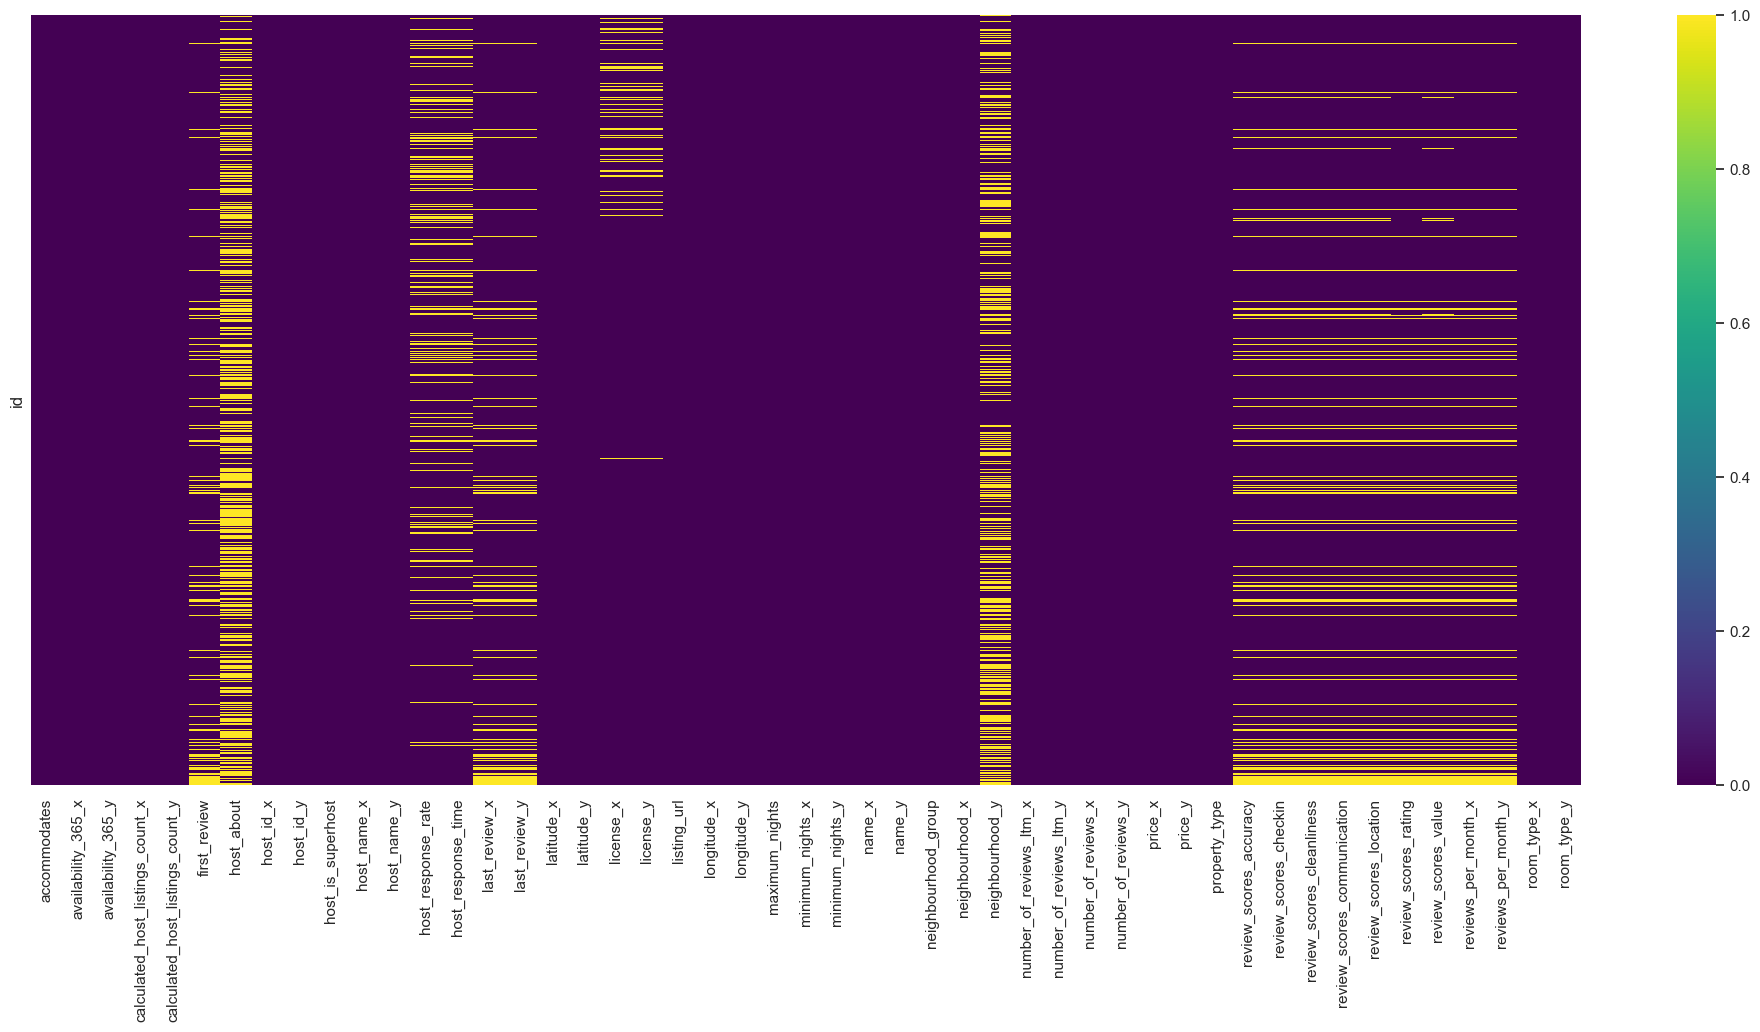

In [148]:
plt.figure(figsize=(25, 10))
sns.heatmap(oporto.isnull(), yticklabels=False, cbar=True, cmap="viridis");

In [149]:
oporto = oporto.drop(['availability_365_y', 'availability_365_y', 'availability_365_y', 'host_id_y', 'host_name_y', 'last_review_y', 'latitude_y', 'license_y', 'longitude_y', 'minimum_nights_y', 'name_y', 'neighbourhood_y', 'number_of_reviews_ltm_y', 'number_of_reviews_y', 'price_y', 'reviews_per_month_y', 'room_type_y'], axis=1)

oporto = oporto.rename(columns={col: col.replace('_x', '') for col in oporto.columns if '_x' in col})


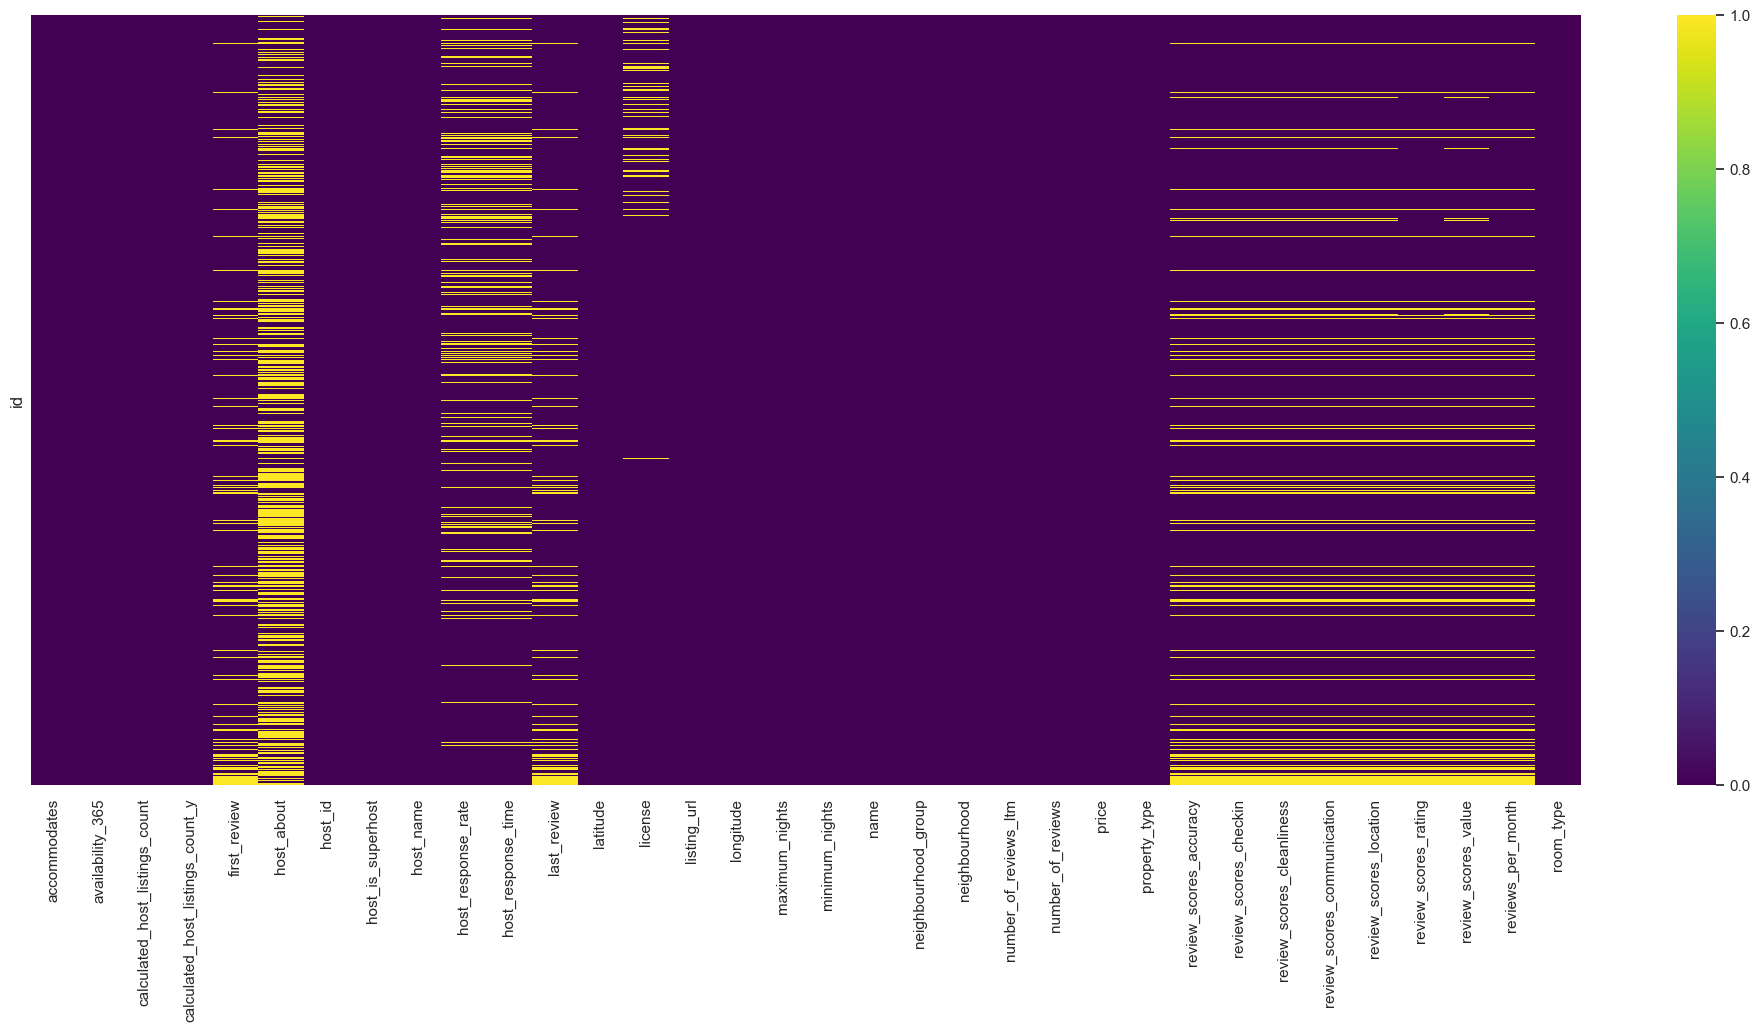

In [150]:
plt.figure(figsize=(25, 10))
sns.heatmap(oporto.isnull(), yticklabels=False, cbar=True, cmap="viridis");

In [151]:
oporto.head()

,accommodates,availability_365,calculated_host_listings_count,calculated_host_listings_count_y,first_review,host_about,host_id,host_is_superhost,host_name,host_response_rate,...,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type
id,,,,,,,,,,,,,,,,,,,,,
41339,5,93,1,1,2013-05-15,"Olá, sou a Paula e adoro a minha cidade!\r\nAd...",180050,f,Paula,NaN,...,Entire rental unit,4.70,4.85,4.90,4.80,4.55,4.70,4.65,0.17,Entire home/apt
55111,5,0,3,3,2015-07-18,I am architect and I born in Paredes-Porto. I'...,259711,t,Isabel E João,NaN,...,Entire rental unit,4.80,4.87,4.67,4.87,4.79,4.80,4.79,0.17,Entire home/apt
73828,5,0,3,3,2015-05-09,I am architect and I born in Paredes-Porto. I'...,259711,t,Isabel E João,NaN,...,Entire rental unit,5.00,5.00,4.83,5.00,4.92,4.83,4.75,0.13,Entire home/apt
86388,2,314,8,8,2011-04-26,I love to host. And i love to know people's Hu...,185209,t,João,100%,...,Private room in rental unit,4.76,4.93,4.65,4.93,4.87,4.74,4.76,1.37,Private room
87873,4,281,3,3,2012-05-14,"Hi, my name is Paula and I'm renting out two l...",480980,t,Paula,100%,...,Entire rental unit,4.87,4.97,4.89,4.94,4.51,4.79,4.81,1.74,Entire home/apt


In [152]:
oporto.to_csv("output/oporto.csv")

## 1.1. <a id='toc1_1_'></a>[Análisis exploratorio](#toc0_)

### 1.1.1. <a id='toc1_1_1_'></a>[Vecindario (IGUAL NO DEBO PONER VECINDARIO)](#toc0_)

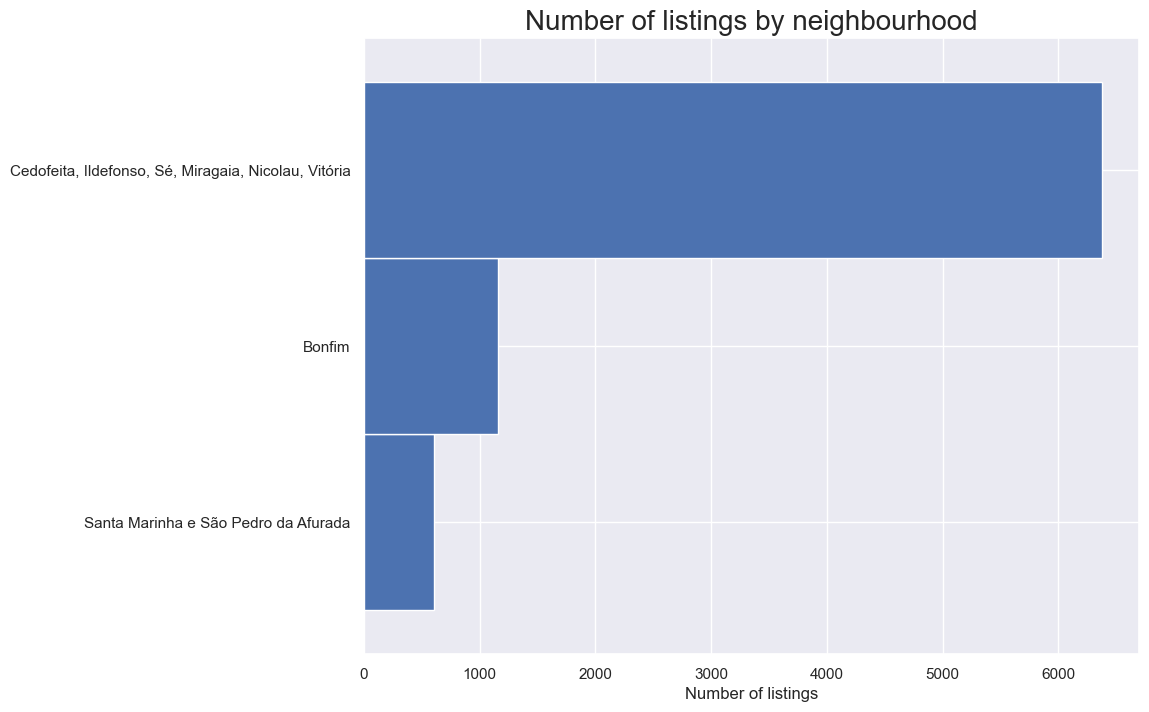

In [153]:
feq=oporto['neighbourhood'].value_counts().sort_values(ascending=True)
feq = feq[feq>500]
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

La Unión de las Parroquias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória, también conocida como Unión de Parroquias del Centro Histórico de Oporto, es una parroquia portuguesa del municipio de Oporto, creada por la Ley n.º 11-A/2013 de 28 de enero, que une las antiguas parroquias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau y Vitória.

Tiene una superficie total de 5,43 km², una población de 37.436 habitantes (2021) y una densidad de población de 7.447,5 habitantes por km².

En resumen, la Unión de Parroquias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória es una entidad administrativa portuguesa que se creó en 2013, que unió seis antiguas parroquias y ahora se conoce como la Unión de Parroquias del Centro Histórico de Oporto. La parroquia tiene una población de alrededor de 37.436 personas y una densidad de población bastante alta de 7.447,5 habitantes por km².

La palabra "freguesia" proviene del latín "filium ecclesiae", que significa "hijo de la iglesia". En Portugal, el antiguo Imperio Portugués y el Imperio de Brasil, una freguesia es la unidad administrativa más pequeña y obligatoria de los municipios, similar a una parroquia civil en otros países. Cada municipio tiene al menos una freguesia, y en algunos casos el territorio de una freguesia coincide con el del municipio.

### 1.1.2. <a id='toc1_1_2_'></a>[Filtro de distancias](#toc0_)

La fórmula de Haversine es una fórmula matemática que se utiliza para calcular la distancia entre dos puntos en la superficie de una esfera, como la Tierra. La fórmula se basa en la longitud y la latitud de los dos puntos, y utiliza la ley de los cosenos para calcular la distancia entre ellos.

La fórmula de Haversine se puede expresar de la siguiente manera:

$$d = 2 R * \arcsin\left(\sqrt{\sin^2\left(\frac{lat_2-lat_1}{2}\right) + \cos(lat_1)\cos(lat_2)\sin^2\left(\frac{lon_2-lon_1}{2}\right)}\right)$$

donde:

- d es la distancia entre los dos puntos en la superficie de la esfera
- R es el radio de la esfera (en metros, kilómetros, millas, etc.)
- $lat_1$ y $lat_2$ son las latitudes de los dos puntos (en radianes o grados)
- $lon_1$ y $lon_2$ son las longitudes de los dos puntos (en radianes o grados)

In [154]:
df_distancia = filtrar_por_distancia(oporto,200)

In [155]:
# Reseteamos el índice de df_distancia
df_distancia = df_distancia.reset_index() 
df_distancia.to_csv('output/distancias.csv')

In [156]:
lats = df_distancia['latitude'].tolist()
lons = df_distancia['longitude'].tolist()
locations = list(zip(lats, lons)) #Guardamos latitudes y longitudes, hacemos una tupla y las cambiamos a una lista.

map1 = folium.Map(location=[41.1496, -8.6109], zoom_start=12) # Le das una lat y lon inicial y un zoom inicial para representar el mapa
FastMarkerCluster(data=locations).add_to(map1) # Te añade las localizaciones al mapa generado anteriormente
folium.Marker(location=[41.1496, -8.6109]).add_to(map1)
map1

## 1.2. <a id='toc1_2_'></a>[Tipos de propiedades y habitaciones](#toc0_)

### 1.2.1. <a id='toc1_2_1_'></a>[Tipos de habitaciones](#toc0_)

Buscar info sobre ley en oporto 

_El tipo de habitación es muy importante en Ámsterdam, porque Ámsterdam tiene la regla de que las casas/apartamentos completos solo se pueden alquilar a través de Airbnb por un máximo de 60 días al año. A continuación, podemos ver que esta restricción se aplica a la mayoría de los listados._

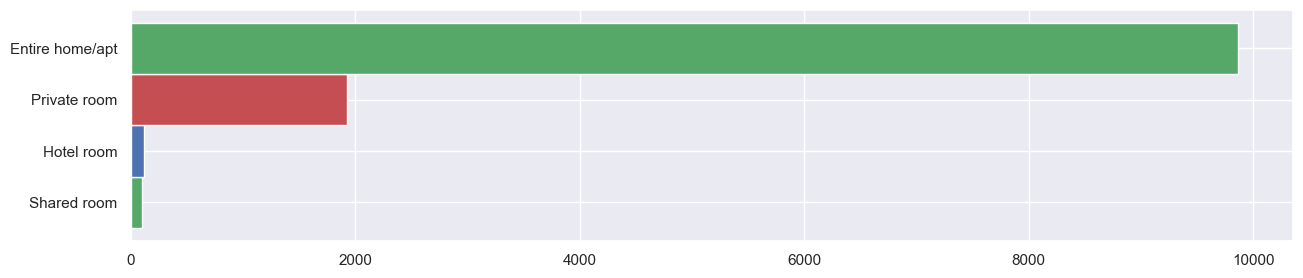

In [157]:
freq = df_distancia['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

### 1.2.2. <a id='toc1_2_2_'></a>[Tipos de propiedades](#toc0_)

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [158]:
df_distancia['property_type'].unique()

array(['Entire rental unit', 'Private room in rental unit',
       'Private room in home', 'Boat', 'Entire home', 'Tiny home',
       'Entire guesthouse', 'Private room in guesthouse', 'Entire loft',
       'Entire villa', 'Farm stay', 'Entire condo',
       'Private room in condo', 'Room in boutique hotel',
       'Entire townhouse', 'Entire serviced apartment',
       'Private room in townhouse', 'Private room in hostel',
       'Shared room in hostel', 'Shared room in bed and breakfast',
       'Entire cottage', 'Entire chalet', 'Windmill', 'Entire cabin',
       'Private room in guest suite', 'Camper/RV', 'Room in hostel',
       'Private room in bed and breakfast', 'Private room in villa',
       'Earthen home', 'Private room in cottage',
       'Private room in nature lodge', 'Entire bed and breakfast',
       'Shared room in home', 'Barn', 'Entire guest suite',
       'Shared room in rental unit', 'Private room in loft',
       'Private room in earthen home', 'Private room in bo

_Sin embargo, muchos de esos tipos de propiedades tienen muy pocos listados en Ámsterdam. En la figura a continuación, solo mostramos tipos de propiedades con al menos 100 listados. Como podemos ver, la gran mayoría de las propiedades en Ámsterdam son apartamentos._

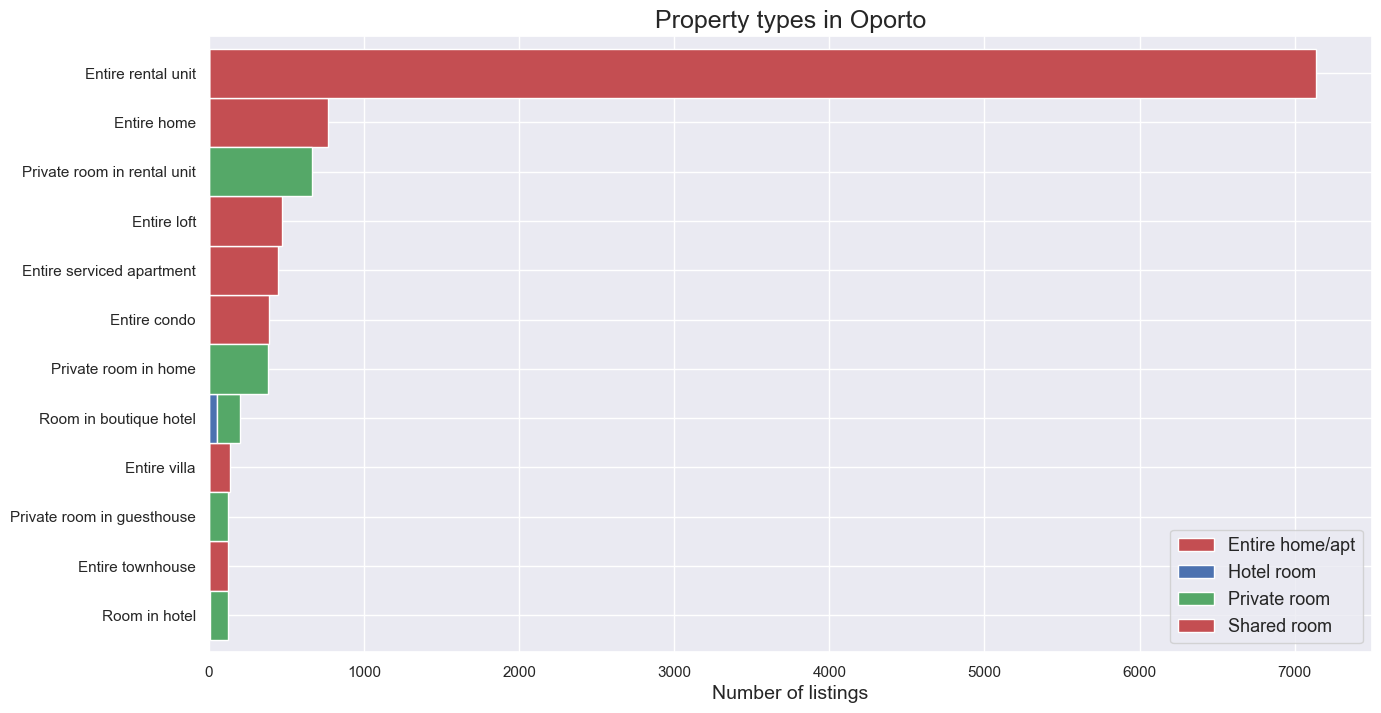

In [159]:
prop = df_distancia.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Oporto', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 1.3. <a id='toc1_3_'></a>[Número de alojados](#toc0_)
_
Como era de esperar, la mayoría de los listados son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio._

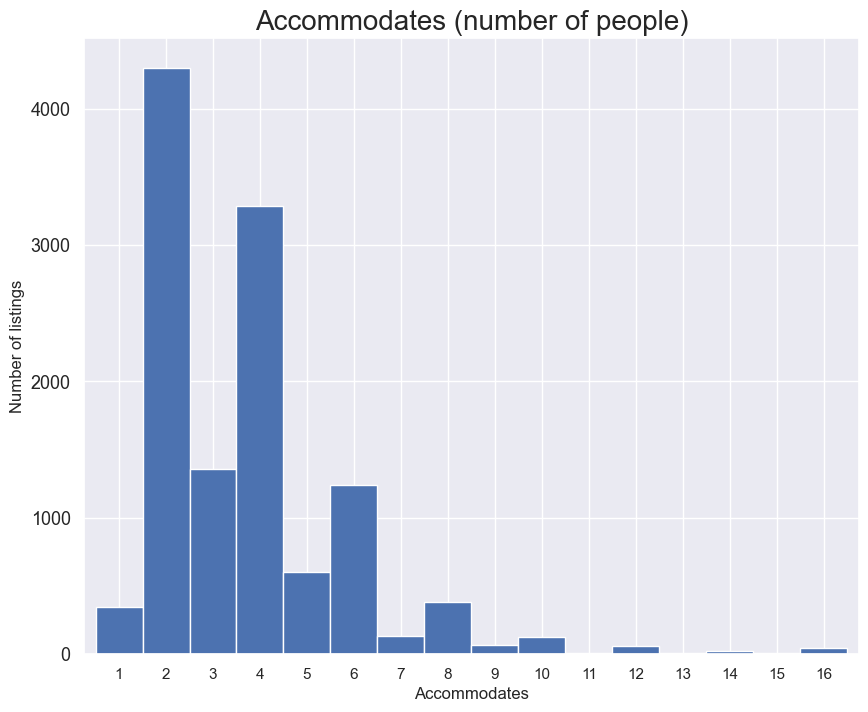

In [160]:
feq=df_distancia['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

_Sin embargo, Ámsterdam tiene una restricción adicional. Debido a las consideraciones de riesgo de incendio y también teniendo en cuenta un posible grupo ruidoso, los propietarios solo pueden alquilar su propiedad a grupos con un máximo de 4 personas. ¡Esto realmente significa que las listas que indican que el número máximo de personas es superior a 4 están infringiendo esta regla!_

In [161]:
df_distancia[df_distancia['accommodates']>15]

,id,accommodates,availability_365,calculated_host_listings_count,calculated_host_listings_count_y,first_review,host_about,host_id,host_is_superhost,host_name,...,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,distancia
270,1543906,16,347,4,4,2015-06-05,"Professor, disponível para acompanhar hospedes...",8228380,f,Carlos,...,4.46,4.86,4.54,4.89,4.32,4.57,4.27,0.43,Entire home/apt,38.871003
433,3920836,16,13,7,7,2018-11-09,NaN,20310699,f,Andre,...,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.02,Entire home/apt,38.992127
539,5824521,16,49,1,1,2015-04-27,NaN,30231944,t,Sara,...,4.93,4.94,4.92,4.93,4.89,4.89,4.80,2.49,Entire home/apt,0.767860
669,6151673,16,281,7,7,2015-08-03,"Mature professional, passionate about customer...",181902,f,Jose Luz,...,4.89,4.93,4.84,4.84,4.78,4.76,4.66,1.10,Entire home/apt,0.900562
1054,10605132,16,248,8,8,2016-02-17,"Sou agrónomo, enólogo, viticultor e produtor d...",27267172,t,Marcos,...,4.96,4.87,4.92,4.80,4.81,4.96,4.81,1.18,Entire home/apt,1.951571
1278,12701115,16,363,1,1,2016-06-13,NaN,69041880,f,Maria José,...,4.65,4.96,4.70,4.78,4.74,4.83,4.70,0.29,Entire home/apt,38.695617
1626,14269952,16,363,7,7,2016-08-16,"Olá, o meu nome é Jorge. Nascido e criado no P...",25193912,f,Jorge,...,4.94,5.00,4.94,4.94,4.83,5.00,5.00,0.23,Entire home/apt,5.282376
1926,16803834,16,348,5,5,2017-04-08,I´m the person you want to meet in the city of...,625145,f,Manuel & Family,...,4.40,4.45,4.40,4.24,4.52,4.35,4.25,1.52,Entire home/apt,0.745026
2045,17829219,16,205,6,6,2018-01-02,NaN,118270240,f,Praça,...,4.92,4.98,4.84,4.96,4.73,4.85,4.84,1.19,Entire home/apt,1.314813
2261,18178588,16,244,1,1,2017-12-10,NaN,125415937,f,Daniel Gonçalves,...,4.89,4.93,4.80,4.85,4.83,4.94,4.86,1.57,Entire home/apt,18.259403


## 1.4. <a id='toc1_4_'></a>[Analítica al servicio del gobierno. (PENDIENTE DE REVISAR LA LEY DE OPORTO )](#toc0_)

## 1.5. <a id='toc1_5_'></a>[Consejos al turismo](#toc0_)

### 1.5.1. <a id='toc1_5_1_'></a>[Precio medio por vecindario](#toc0_)

_Para comparar "manzanas con manzanas" solo seleccionaremos el tipo de alojamiento más común, que es el alojamiento para 2 personas. Como era de esperar, el alojamiento en el centro de la ciudad es el más caro._

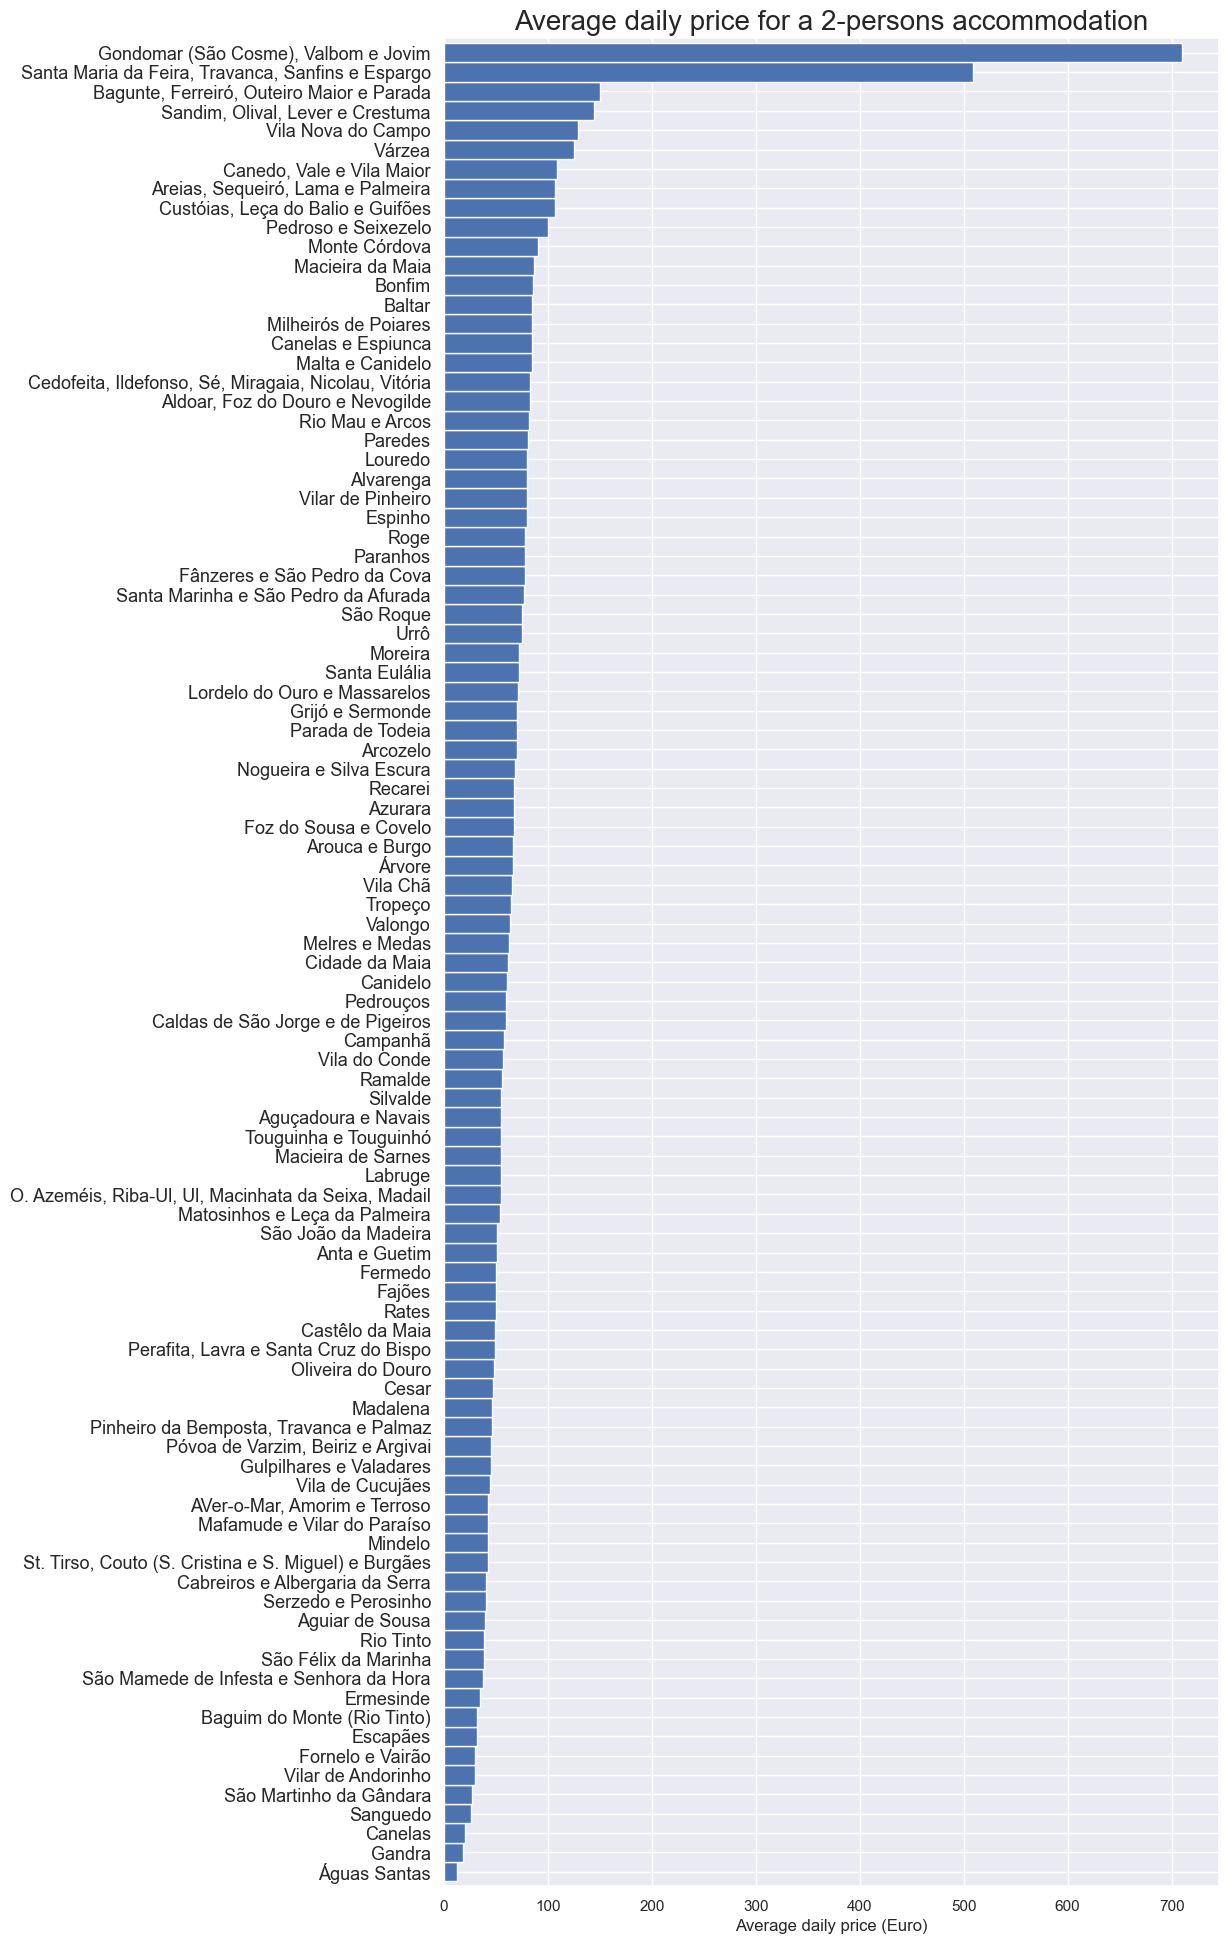

In [162]:
feq = df_distancia[df_distancia['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10,24), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

#### 1.5.1.1. <a id='toc1_5_1_1_'></a>[Mapa del precio medio por localizaciones](#toc0_)

In [163]:
feq = df_distancia[df_distancia['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
porto = gpd.read_file("http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/visualisations/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
porto = pd.merge(porto, feq, on='neighbourhood', how='left')
porto.rename(columns={'price': 'average_price'}, inplace=True)
porto.average_price = porto.average_price.round(decimals=0)
porto = porto.dropna(subset=['average_price'])
map_dict = porto.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red','purple'], vmin=min(map_dict.values()), vmax=max(map_dict.values()), caption='Average price')

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    if value is None:
        return '#4da8a8'
    else:
        return color_scale(value)

map3 = folium.Map(location=[41.1496, -8.6109], zoom_start=11)
folium.GeoJson(data=porto, name='Oporto',
                tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'], labels=True, sticky=False),
                style_function=lambda feature: {
                    'fillColor': get_color(feature),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 0.9
                },
                highlight_function=lambda feature: {
                    'weight': 3,
                    'fillColor': get_color(feature),
                    'fillOpacity': 0.8
                }).add_to(map3)
folium.Marker(location=[41.1496, -8.6109]).add_to(map3)
map3.add_child(color_scale)

#### 1.5.1.2. <a id='toc1_5_1_2_'></a>[Veamos el tipo de vivienda a alquilar por colores y localizaciones](#toc0_)

In [170]:
from folium.plugins import FastMarkerCluster

# con esto vamos a crear una agrupación automática según los marcadores cercanos basado en el tipo de habitación para mejorar la carga.
map_type = folium.Map(location=[41.1496, -8.6109], zoom_start=11)

# Creamos colorines para cada tipo de habitación
colors = {'Entire home/apt': 'orange', 'Private room': 'red', 'Shared room': 'purple', 'Hotel room': 'green'}

def room_type_icon(room_type):
    color = colors.get(room_type, 'blue')
    return folium.Icon(color=color, icon_color=color, prefix='fa', icon='circle')

# Crear una lista vacía para las coordenadas y datos de las habitaciones
room_data = []
for i in range(len(df_distancia)):
    room_type = df_distancia['room_type'][i]
    latitude = df_distancia['latitude'][i]
    longitude = df_distancia['longitude'][i]
    color = colors.get(room_type, 'blue')
    # Añadir la información de la habitación a la lista
    room_data.append([latitude, longitude, room_type, color])

# Usar FastMarkerCluster para agrupar los marcadores de habitaciones cercanas basados en el tipo de habitación
marker_cluster = FastMarkerCluster(room_data, callback=""" function (row) { var icon = L.AwesomeMarkers.icon({ icon: 'circle', prefix: 'fa', markerColor: row[3], iconColor: row[3] }); var marker = L.marker(new L.LatLng(row[0], row[1]), {icon: icon}); marker.bindPopup(row[2]); return marker; } """)
marker_cluster.add_to(map_type)

# el html mejor así
legend_html = ''' 
<div style="bottom: 30px; 
            right: 30px;
            width: 120px; 
            height: 200px; 
            border:2px solid grey; 
            z-index:9999; 
            font-size:14px; 
            background-color: rgba(255, 255, 255, 0.7); ">
    <p style="margin: 10px;"><b>Legend</b></p>
    <p style="margin: 10px;"><span style='color: orange;'>&#9679;</span> Entire home/apt</p>
    <p style="margin: 10px;"><span style='color: red;'>&#9679;</span> Private room</p>
    <p style="margin: 10px;"><span style='color: purple;'>&#9679;</span> Shared room</p>
    <p style="margin: 10px;"><span style='color: green;'>&#9679;</span> Hotel room</p>
</div>
'''

legend = folium.features.DivIcon(html=legend_html)
folium.Marker(location=[41.1496, -8.6109], icon=legend).add_to(map_type)

# Mostramos mapa
map_type


In [165]:
df_distancia.tail()

,id,accommodates,availability_365,calculated_host_listings_count,calculated_host_listings_count_y,first_review,host_about,host_id,host_is_superhost,host_name,...,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,distancia
12008,779127249810268197,2,206,1,1,NaN,"\r\nA casa é o centro de tudo,o nosso reduto d...",55909094,f,Maria Jose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,4.883005
12009,779596413035604787,2,364,3,3,NaN,NaN,487257931,f,George,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,16.807851
12010,779712655687956624,2,172,5,5,NaN,The art of Portuguese hospitality is to make o...,409325747,t,Claudia & Mário,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,0.980546
12011,779753944728289358,3,365,2,2,NaN,"Moro em Portugal, gosto de viajar e ter novas ...",478851105,f,Marcelo E Breno,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,4.170518
12012,779861992110623008,4,352,1,1,NaN,NaN,491094056,f,Maria,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,2.146106


#### Qué áreas de Oporto serán las más rentables para alquilar

Basándonos en las localizaciones más turísticas de la ciudad de Oporto haremos una correlación con el precio para poder determinar cuáles son las zonas más rentables para tener un Airbnb.

### 1.5.2. <a id='toc1_5_2_'></a>[Sobre la movidita de los pisos de AirBnB en Portugal.](#toc0_)

- https://www.elmundo.es/economia/2018/07/18/5b4e2989ca47411d0c8b4572.html
- Igual estaría bueno bajarse los datos de años anteriores para ver la comparativa de *aumento de pisos de airbnb*

https://www.elmundo.es/economia/2018/07/18/5b4e2989ca47411d0c8b4572.html

##### 1.5.2.1.1. <a id='toc1_5_2_1_1_'></a>[SNIPET DE VS Code](#toc0_)

<!-- // Place your key bindings in this file to override the defaults
[
    {
        "key": "ctrl+shift+m",
        "command": "extension.multiCommand.execute",
        "args": { "sequence": [
            "editor.action.clipboardCopyAction",
            "editor.emmet.action.wrapWithAbbreviation",
            {
                "command": "editor.action.insertSnippet",
                "args": {
                    "Cambiar a texto rojo": {
                        "prefix": "redtext",
                        "body": "<font color='${1:red}'>$TM_SELECTED_TEXT</font>"
                    }
                }
            }
        ]},
        "when": "editorTextFocus && !editorReadonly"
    },
    
] -->

    <!-- {
        "key": "ctrl+shift+c",
        "command": "extension.multiCommand.execute",
        "args": { "sequence": [
            "editor.action.clipboardCopyAction",
            "editor.emmet.action.wrapWithAbbreviation",
            
        ]},
        "when": "editorTextFocus && !editorReadonly"
    }, -->

In [166]:
# [
    
#         {
#             "key": "ctrl+shift+c",
#             "command": "extension.multiCommand.execute",
#             "args": { "sequence": [
#                 "editor.action.clipboardCopyAction",
#                 {
#                     "command": "editor.action.insertSnippet",
#                     "args": {
#                         "snippet": "<font color=\"$TM_SELECTED_TEXT$\">$TM_SELECTED_TEXT$</font>"
#                     }
#                 }
#             ]},
#             "when": "editorTextFocus && !editorReadonly && editorLangId == 'markdown'"
#         }
#     ]

## 1.6. <a id='toc1_6_'></a>[Modelos predictivos para predecir el valor de tu alojamiento en Oporto.](#toc0_)

Target será price y el resto de columnas serán las features, pero supongo que aquí solo entran como features las que sean variables como tipo de apartamento, 